In [27]:
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('/home/chef/src/DAT6003/data/processed/nlp_sentiment_analysis.csv')

In [3]:
# reorder columns to put sentiment columns before text column
df1 = df[['sentiment_label', 'sentiment_score', 'parent_issue_id'] + [col for col in df.columns if col not in ['sentiment_label', 'sentiment_score', 'parent_issue_id']]]
df1.head()

,sentiment_label,sentiment_score,parent_issue_id,Unnamed: 0,created_at,author,author_location,type,text
0,positive,0.617641,NaN,0,2018-11-05T21:35:51Z,ZhaoyueCheng,NaN,issue,Thanks a lot for the port! I have some minor q...
1,negative,0.798381,0.0,0_0,2018-11-05T22:01:47Z,ZhaoyueCheng,NaN,comment,It also seems to me that the SQuAD VERSION can...
2,negative,0.796224,0.0,0_1,2018-11-05T23:20:46Z,abeljim,NaN,comment,It also seems to me that the SQuAD VERSION can...
3,neutral,0.802384,0.0,0_3,2018-11-06T02:05:22Z,abeljim,NaN,comment,"Just ran on 1 GPU batch size of 10, the result..."
4,neutral,0.538394,0.0,0_4,2018-11-06T03:48:21Z,ZhaoyueCheng,NaN,comment,"Sure, Thanks, I'm checking for the reason too,..."


In [4]:
# count how many of each sentiment label
df1['sentiment_label'].value_counts()

sentiment_label
neutral     26444
positive     6856
negative     6753
Name: count, dtype: int64

In [5]:
# view the spread of sentiment score confidence
df1['sentiment_score'].describe()

count    40053.000000
mean         0.734860
std          0.135882
min          0.352357
25%          0.620786
50%          0.747841
75%          0.849596
max          0.990493
Name: sentiment_score, dtype: float64

In [6]:
# Visualising some results
counts_df = df1['sentiment_score'].value_counts()
counts_df.head()

sentiment_score
0.530812    102
0.837178     92
0.837178     85
0.863279     50
0.701751     24
Name: count, dtype: int64

In [7]:
len(counts_df)

39050

Text(0.5, 1.0, 'Number of posts by classification label')

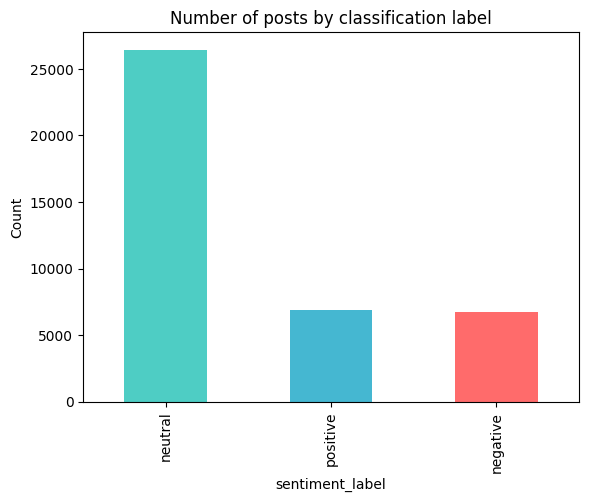

In [25]:
df1['sentiment_label'].value_counts().plot(kind='bar',color=['#4ECDC4', '#45B7D1',  '#FF6B6B'])
plt.ylabel('Count')
plt.title('Number of posts by classification label')

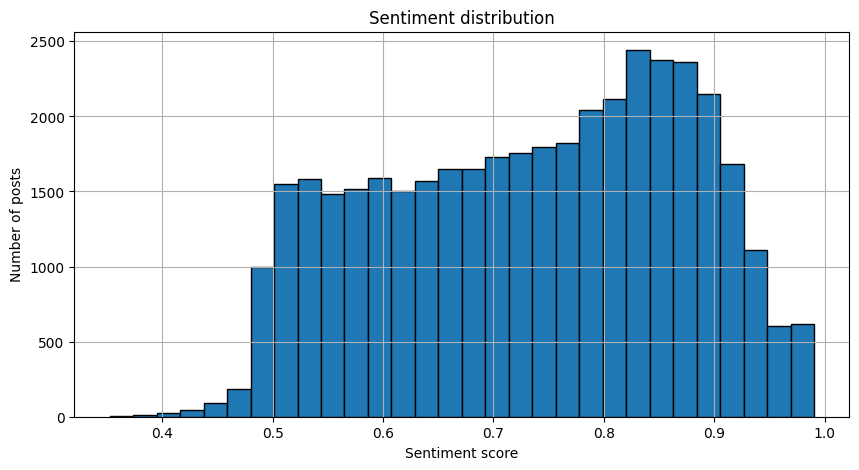

In [ ]:
plt.figure(figsize=(10, 5))
df1['sentiment_score'].hist(bins=30, edgecolor='black')
plt.ylabel("Number of posts")
plt.xlabel("Sentiment score")
plt.title("Sentiment distribution")

Text(0.5, 1.0, 'Average sentiment confidence by classification')

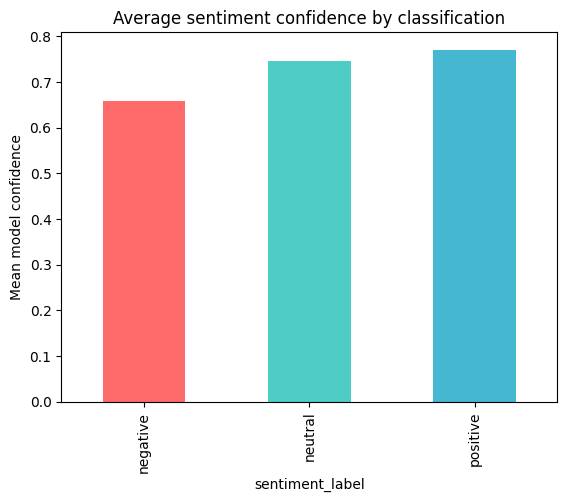

In [23]:
df.groupby("sentiment_label")["sentiment_score"].mean().plot(kind="bar", color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.ylabel("Mean model confidence")
plt.title("Average sentiment confidence by classification")

In [18]:
# Convert created_at column to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'])
df1['created_at'].head()

0   2018-11-05 21:35:51+00:00
1   2018-11-05 22:01:47+00:00
2   2018-11-05 23:20:46+00:00
3   2018-11-06 02:05:22+00:00
4   2018-11-06 03:48:21+00:00
Name: created_at, dtype: datetime64[ns, UTC]

/tmp/ipykernel_84918/1118159518.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sentiment_over_time_weekly = df1_sorted.groupby([pd.Grouper(freq='M'), 'sentiment_label']).size().unstack(fill_value=0)


<Figure size 1400x600 with 0 Axes>

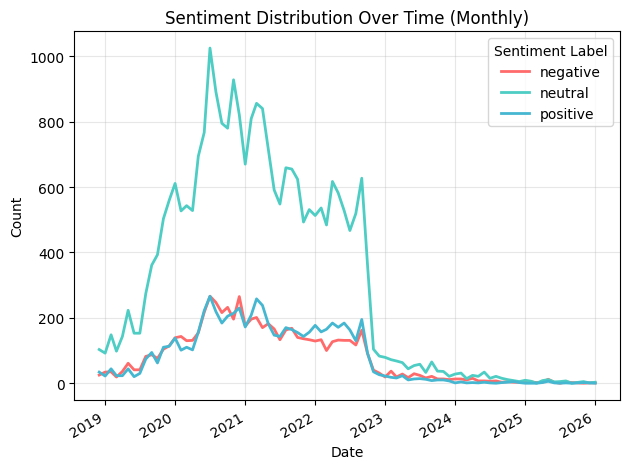

In [26]:
# Sentiment distribution over time (weekly aggregation for cleaner view)
df1_sorted = df1.sort_values('created_at')
df1_sorted.set_index('created_at', inplace=True)
sentiment_over_time_weekly = df1_sorted.groupby([pd.Grouper(freq='M'), 'sentiment_label']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
sentiment_over_time_weekly.plot(kind='line', linewidth=2, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Sentiment Distribution Over Time (Monthly)')
plt.legend(title='Sentiment Label')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

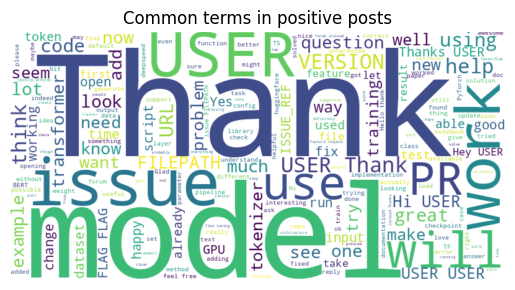

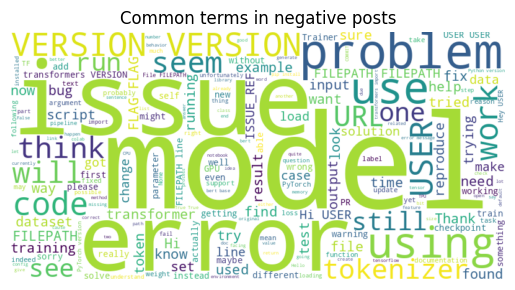

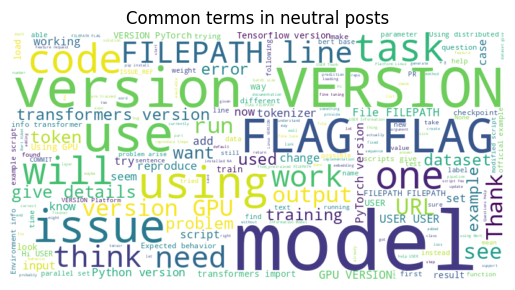

In [30]:
# Plot a wordcloud
def plot_wordcloud(texts, title):
    wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(texts))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

for label in ["positive", "negative", "neutral"]:
    texts = df[df["sentiment_label"] == label]["text"].dropna().tolist()
    plot_wordcloud(texts, f"Common terms in {label} posts")

<Figure size 1400x600 with 0 Axes>

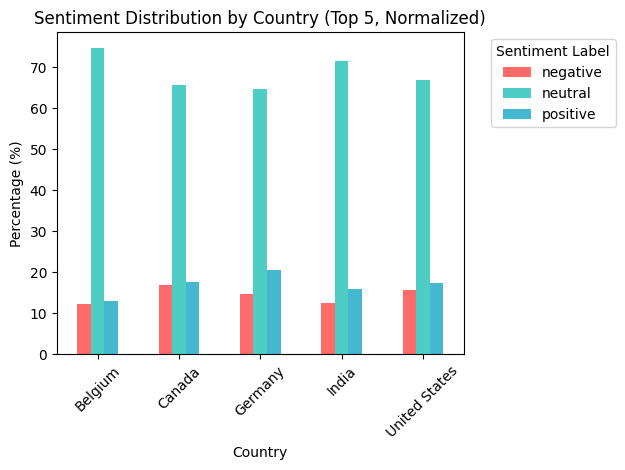

In [34]:
# Get top 5 countries (excluding null/nan)
top_countries = df1.dropna(subset=['author_location'])['author_location'].value_counts().head(5).index

# Create mapping from country codes to country names using geonamescache
import geonamescache
gc = geonamescache.GeonamesCache()
country_map = {country['iso']: country['name'] for country in gc.get_countries().values()}

# Count sentiment labels by country and normalize to percentages
country_sentiment_counts = df1[df1['author_location'].isin(top_countries)].groupby(['author_location', 'sentiment_label']).size().unstack(fill_value=0)

# Normalize to percentages (each country row sums to 100%)
country_sentiment = country_sentiment_counts.div(country_sentiment_counts.sum(axis=1), axis=0) * 100

# Rename country codes to country names
country_sentiment.index = country_sentiment.index.map(lambda x: country_map.get(x, x))

# Plot
plt.figure(figsize=(14, 6))
country_sentiment.plot(kind='bar', color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.ylabel('Percentage (%)')
plt.xlabel('Country')
plt.title('Sentiment Distribution by Country (Top 5, Normalized)')
plt.legend(title='Sentiment Label', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()